In [6]:
# imports 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input ,Dense ,Dropout ,LayerNormalization ,Softmax ,LeakyReLU
from keras import Model
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

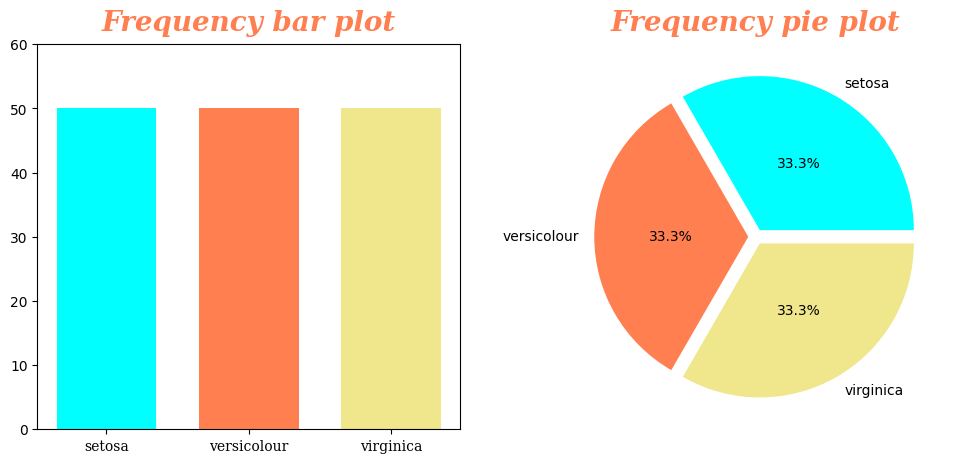

In [2]:
# preprocessing
data =load_iris(return_X_y =True) 
x_norm =(data[0] /np.max(data[0] ,axis =0)).astype(np.float32)
label =data[1].reshape(-1,1).astype(np.int32)
xtr ,xte ,ytr ,yte =train_test_split(x_norm ,label ,test_size =0.2)
label_series =pd.Series(label[:,0] ,name ='label')
label_count =[]
label_class =[]
for i in range(3) : 
    label_count.append(label_series.value_counts()[i])
    label_class.append(i) 
plt.figure(num =1 ,dpi =100 ,figsize =(12,5))
def font_config(family ,color ,weight ,style ,size) : 
    font ={'family': family,
            'color':  color,
            'weight': weight,
            'fontstyle' : style ,
            'size': size
        }
    return font
font_ticks =font_config('serif' ,'black' ,'normal' ,'normal' ,10)
font_title =font_config('serif' ,'coral' ,'bold' ,'italic' ,20)
colors =['aqua' ,'coral' ,'khaki']
labels =['setosa' ,'versicolour' ,'virginica']
plt.subplot(121)
plt.bar(label_class ,label_count ,width =0.7 ,color =colors)
plt.xticks(ticks =label_class ,labels =labels ,fontdict =font_ticks) 
plt.ylim((0 ,label_count[0] +10))
plt.title(label ='Frequency bar plot' ,pad =10 ,fontdict =font_title)
plt.subplot(122)
plt.pie(label_count ,
        colors =colors ,
        labels =labels ,
        explode =[0.05 ,0.05 ,0.05] ,
        startangle =0 ,
        autopct ='%1.1f%%' ,
        pctdistance =0.5 ,
        labeldistance =1.1 ,
        textprops ={'size' : 10})
plt.title(label ='Frequency pie plot' ,pad =10 ,fontdict =font_title)
plt.show()

In [8]:
# model definition
def create_model(drate ,nslop ,lr): 
    input =Input(shape =(4,))
    dense1 =Dense(units =1024)(input)
    norm1 =LayerNormalization()(dense1) 
    act1 =LeakyReLU(negative_slope =nslop)(norm1) 
    drop1 =Dropout(rate =drate)(act1) 
    dense2 =Dense(units =524)(drop1)
    norm2 =LayerNormalization()(dense2) 
    act2 =LeakyReLU(negative_slope =nslop)(norm2) 
    drop2 =Dropout(rate =drate)(act2)
    dense3 =Dense(units =256)(drop2)
    norm3 =LayerNormalization()(dense3) 
    act3 =LeakyReLU(negative_slope =nslop)(norm3) 
    drop3 =Dropout(rate =drate)(act3)
    dense4 =Dense(units =128)(drop3)
    norm4 =LayerNormalization()(dense4) 
    act4 =LeakyReLU(negative_slope =nslop)(norm4) 
    drop4 =Dropout(rate =drate)(act4)
    dense5 =Dense(units =64)(drop4)
    norm5 =LayerNormalization()(dense5) 
    act5 =LeakyReLU(negative_slope =nslop)(norm5) 
    drop5 =Dropout(rate =drate)(act5)
    dense6 =Dense(units =32)(drop5)
    norm6 =LayerNormalization()(dense6) 
    act6 =LeakyReLU(negative_slope =nslop)(norm6) 
    drop6 =Dropout(rate =drate)(act6)
    dense7 =Dense(units =16)(drop6)
    norm7 =LayerNormalization()(dense7) 
    act7 =LeakyReLU(negative_slope =nslop)(norm7) 
    drop7 =Dropout(rate =drate)(act7)
    dense8 =Dense(units =3)(drop7)
    norm8 =LayerNormalization()(dense8) 
    act8 =Softmax()(norm8) 
    model =Model(inputs =input ,outputs =act8)
    model.compile(optimizer =Adam(learning_rate =lr) ,loss =SparseCategoricalCrossentropy)
    return model

In [10]:
# grid search cross validation
modelCV =KerasClassifier(model=create_model ,
                         loss =SparseCategoricalCrossentropy ,
                         optimizer =Adam(learning_rate=0.001) ,
                         epochs =10 ,
                         batch_size =64 ,
                         verbose =0
                         )
params ={ 
    'model__drate' :[0.4 ,0.5] ,
    'model__nslop' :[0.2 ,0.3] ,
    'model__lr':[0.002 ,0.003]
}
gs =GridSearchCV(modelCV ,params ,cv =3)
gs_result =gs.fit(xtr ,ytr)
best_params =gs_result.best_params_
model =create_model(best_params['model__drate'] ,best_params['model__nslop'] ,best_params['model__lr'])

In [1]:
# train model 
epoch =200
batch_size =64
fpath ='checkpoint.weights.h5'
c_point =keras.callbacks.ModelCheckpoint(filepath =fpath ,monitor ='val_loss' ,mode ='min' ,save_weights_only =True ,save_best_only =True)
early_stoping =keras.callbacks.EarlyStopping(monitor ='val_loss' ,patience =60 ,restore_best_weights =True)
train =model.fit(xtr ,ytr ,epochs =epoch ,batch_size =batch_size ,validation_data =(xte ,yte) ,callbacks =[early_stoping ,c_point] ,verbose =2)

In [27]:
# model evalulation
Y =model.predict(xte) 
Yte =[]
for predict in Y : 
  lbl =np.where(predict ==np.max(predict))[0][0]
  Yte.append(lbl)
Yte =np.asarray(Yte).reshape(-1,1)
test_acc_per =accuracy_score(y_true =yte ,y_pred =Yte) *100
print(f'accuracy_score_for_test_data : {test_acc_per} %')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
accuracy_score_for_test_data : 96.66666666666667 %


In [1]:
# val/loss plot
plt.style.use('dark_background')
plt.figure(num =1 ,figsize =(12,7) ,dpi =100)
font_title =font_config('serif' ,'black' ,'normal' ,'italic' ,20)
font_label =font_config('serif' ,'black' ,'normal' ,'italic' ,15)
plt.subplot(121)
plt.plot(train.history['loss'] ,color ='blue' ,lw =5  ,label ='loss')
plt.xlim((0 ,epoch))
plt.ylim((np.min(train.history['loss']) ,np.max(train.history['loss'])))
plt.xlabel(xlabel ='epochs' ,labelpad =10 ,loc ='right' ,fontdict =font_label)
plt.ylabel(ylabel ='loss' ,labelpad =10 ,loc ='top' ,fontdict =font_label)
plt.title(label ='loss plot' ,pad =10 ,fontdict =font_title)
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(train.history['val_loss'] ,color ='red' ,lw =5  ,label ='val_loss')
plt.xlim((0 ,epoch))
plt.ylim((np.min(train.history['val_loss']) ,np.max(train.history['val_loss'])))
plt.xlabel(xlabel ='epochs' ,labelpad =10 ,loc ='right' ,fontdict =font_label)
plt.ylabel(ylabel ='val_loss' ,labelpad =10 ,loc ='top' ,fontdict =font_label)
plt.title(label ='val_loss plot' ,pad =10 ,fontdict =font_title)
plt.grid()
plt.legend()
plt.show()